<a href="https://colab.research.google.com/github/KimNikita/machine-learning-practice/blob/main/Anime%20rating%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Постановка задачи

## Задача восстановления регрессии: предсказание ожидаемого конечного пользовательского рейтинга аниме по его характеристикам
## Область применения: упрощение выбора аниме для просмотра из числа вышедших в текущем сезоне года. Проблема состоит в том, что процент действительно "хороших" аниме среди вышедших довольно низок. При этом, чтобы отделить "хорошие" от "плохих", необходимо вручную просмотреть как минимум половину серий, что в худшем случае обернется потерей времени и настроения. А ориентироваться на пользовательский рейтинг первые полгода - бессмысленно ввиду разных причин (конкретика опускается).


# 2. Чтение данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/KimNikita/machine-learning-practice/main/anime-dataset-2023.csv"
data_raw = pd.read_csv(url)

In [ ]:
data_raw.shape

(24905, 24)

In [ ]:
data_raw.head()

anime_id                             Name             English name  \
0         1                     Cowboy Bebop             Cowboy Bebop   
1         5  Cowboy Bebop: Tengoku no Tobira  Cowboy Bebop: The Movie   
2         6                           Trigun                   Trigun   
3         7               Witch Hunter Robin       Witch Hunter Robin   
4         8                   Bouken Ou Beet   Beet the Vandel Buster   

                         Other name Score  \
0                         カウボーイビバップ  8.75   
1                    カウボーイビバップ 天国の扉  8.38   
2                             トライガン  8.22   
3  Witch Hunter ROBIN (ウイッチハンターロビン)  7.25   
4                            冒険王ビィト  6.94   

                                 Genres  \
0         Action, Award Winning, Sci-Fi   
1                        Action, Sci-Fi   
2             Action, Adventure, Sci-Fi   
3  Action, Drama, Mystery, Supernatural   
4      Adventure, Fantasy, Supernatural   

                                            Synopsis   Type Episodes  \
0  Crime is timeless. By the year 2071, humanity ...     TV     26.0   
1  Another day, another bounty—such is the life o...  Movie      1.0   
2  Vash the Stampede is the man with a $$60,000,0...     TV     26.0   
3  Robin Sena is a powerful craft user drafted in...     TV     26.0   
4  It is the dark century and the people are suff...     TV     52.0   

                          Aired  ...         Studios    Source       Duration  \
0   Apr 3, 1998 to Apr 24, 1999  ...         Sunrise  Original  24 min per ep   
1                   Sep 1, 2001  ...           Bones  Original    1 hr 55 min   
2   Apr 1, 1998 to Sep 30, 1998  ...        Madhouse     Manga  24 min per ep   
3   Jul 3, 2002 to Dec 25, 2002  ...         Sunrise  Original  25 min per ep   
4  Sep 30, 2004 to Sep 29, 2005  ...  Toei Animation     Manga  23 min per ep   

                           Rating    Rank Popularity Favorites Scored By  \
0  R - 17+ (violence & profanity)    41.0         43     78525  914193.0   
1  R - 17+ (violence & profanity)   189.0        602      1448  206248.0   
2       PG-13 - Teens 13 or older   328.0        246     15035  356739.0   
3       PG-13 - Teens 13 or older  2764.0       1795       613   42829.0   
4                   PG - Children  4240.0       5126        14    6413.0   

   Members                                          Image URL  
0  1771505  https://cdn.myanimelist.net/images/anime/4/196...  
1   360978  https://cdn.myanimelist.net/images/anime/1439/...  
2   727252  https://cdn.myanimelist.net/images/anime/7/203...  
3   111931  https://cdn.myanimelist.net/images/anime/10/19...  
4    15001  https://cdn.myanimelist.net/images/anime/7/215...  

[5 rows x 24 columns]

# 3. Удаление ненужных столбцов

In [42]:
data = data_raw.drop(data_raw.columns[[0, 1, 3, 9, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23]], axis=1)
data.head()

English name Score                                Genres  \
0             Cowboy Bebop  8.75         Action, Award Winning, Sci-Fi   
1  Cowboy Bebop: The Movie  8.38                        Action, Sci-Fi   
2                   Trigun  8.22             Action, Adventure, Sci-Fi   
3       Witch Hunter Robin  7.25  Action, Drama, Mystery, Supernatural   
4   Beet the Vandel Buster  6.94      Adventure, Fantasy, Supernatural   

                                            Synopsis   Type Episodes  \
0  Crime is timeless. By the year 2071, humanity ...     TV     26.0   
1  Another day, another bounty—such is the life o...  Movie      1.0   
2  Vash the Stampede is the man with a $$60,000,0...     TV     26.0   
3  Robin Sena is a powerful craft user drafted in...     TV     26.0   
4  It is the dark century and the people are suff...     TV     52.0   

     Premiered    Source                          Rating  
0  spring 1998  Original  R - 17+ (violence & profanity)  
1      UNKNOWN  Original  R - 17+ (violence & profanity)  
2  spring 1998     Manga       PG-13 - Teens 13 or older  
3  summer 2002  Original       PG-13 - Teens 13 or older  
4    fall 2004     Manga                   PG - Children

# 4. Удаление ненужных строк (фильтрация)

In [43]:
data = data.loc[data['Score'] != 'UNKNOWN']
data = data.loc[data['Synopsis'] != 'No description available for this anime.']
data = data.loc[data['Episodes'] != '1.0']
data = data.loc[data['Type'].isin(['ONA', 'TV', 'UNKNOWN'])]
data = data.loc[data['Source'].isin(['Original', 'Manga' 'Light novel', '4-koma manga', 'Visual novel', 'Other', 'Novel', 'Game', 'Book', 'Web manga', 'Mixed media', 'Card game', 'Web novel', 'UNKNOWN'])]

## Удаление "плохих" жанров

In [44]:
cid = data.columns.get_loc('Genres')
rows_to_drop=[]
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  if cur.find('Hentai') != -1 or cur.find('Erotica') != -1:
    rows_to_drop.append(i)

data.reset_index(inplace=True)
data.drop(rows_to_drop, inplace=True)
data.drop('index', inplace=True, axis=1)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

## Удаление сиквелов \\ приквелов

In [45]:
def mycmp(name):
  return len(name[0])

names=[]
i=0
for name in data['English name']:
  names.append((name, i))
  i+=1
names = sorted(names, key=mycmp)

rows_to_drop=[]
for index, name in enumerate(names):
  spaces = name[0].count(' ')
  for i in range(index+1, data.shape[0]):
    if names[i][0].count(' ') > spaces and names[i][0].startswith(name[0]):
      rows_to_drop.append(names[i][1])

data.drop(rows_to_drop, inplace=True)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)
data.drop('English name', inplace=True, axis=1)

# 5. Преобразование данных

## Столбец Score

In [46]:
cid = data.columns.get_loc('Score')
for i in range(data.shape[0]):
  cur = round(float(data.iat[i, cid]), 1)
  data.iat[i, cid] = cur

## Столбец Genres

In [47]:
unique_genres={}
cid = data.columns.get_loc('Genres')
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  genres = cur.split(', ')
  for genre in genres:
    if genre in unique_genres:
      unique_genres[genre]+=1
    else:
      unique_genres[genre]=0
unique_genres = sorted(unique_genres.items(), key=lambda item: item[1], reverse=True)
print(data.shape)
unique_genres

(2577, 8)


[('Comedy', 957),
 ('Action', 868),
 ('Fantasy', 701),
 ('Adventure', 590),
 ('Sci-Fi', 582),
 ('Drama', 413),
 ('Slice of Life', 321),
 ('Romance', 307),
 ('Supernatural', 199),
 ('Mystery', 183),
 ('UNKNOWN', 129),
 ('Ecchi', 97),
 ('Sports', 83),
 ('Horror', 68),
 ('Suspense', 46),
 ('Award Winning', 32),
 ('Gourmet', 32),
 ('Boys Love', 20),
 ('Girls Love', 15),
 ('Avant Garde', 11)]

In [48]:
usable_genres=[]
for genre in unique_genres:
  if genre[0] != 'UNKNOWN' and float(genre[1]) > data.shape[0]*0.05:
    usable_genres.append(genre[0])
    data.insert(cid+1, 'Genre ' + genre[0], 0)

usable_genres

['Comedy',
 'Action',
 'Fantasy',
 'Adventure',
 'Sci-Fi',
 'Drama',
 'Slice of Life',
 'Romance',
 'Supernatural',
 'Mystery']

In [49]:
rows_to_drop=[]
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  genres = cur.split(', ')
  f=0
  for genre in genres:
    if genre not in usable_genres:
      f=1
      rows_to_drop.append(i)
      break
  if f==0:
    for genre in genres:
      data.iat[i, data.columns.get_loc('Genre ' + genre)]=1

data.drop(rows_to_drop, inplace=True)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)
data.drop('Genres', inplace=True, axis=1)
data.shape

(2062, 17)

## Столбец Synopsis

In [ ]:
#!pip install pymorphy2

In [50]:
import re
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

def normalize(text):
  text = re.sub(r'[^\w\s]+|[\d]+', '', text).strip()
  text = word_tokenize(text.lower(), language="english")
  norm_text=[]
  for token in text:
    if token not in stop_words:
        norm_text.append(morph.parse(token)[0].normal_form)
  return norm_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
cid = data.columns.get_loc('Synopsis')
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  data.iat[i, cid] = normalize(cur)

# TODO векторизация

data.head()

## Столбец Episodes

In [52]:
cid = data.columns.get_loc('Episodes')
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  if cur != 'UNKNOWN':
    cur = float(cur)
    if cur <= 18:
      data.iat[i, cid] = 'half-season'
    elif 18 < cur <= 36:
      data.iat[i, cid] = 'season'
    elif 36 < cur <= 60:
      data.iat[i, cid] = 'double-season'
    elif 60 < cur:
      data.iat[i, cid] = 'no-season'

## Столбец Premiered

In [53]:
cid = data.columns.get_loc('Premiered')
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  if cur.startswith('spring'):
    data.iat[i, cid] = 'spring'
  elif cur.startswith('summer'):
    data.iat[i, cid] = 'summer'
  elif cur.startswith('fall'):
    data.iat[i, cid] = 'fall'
  elif cur.startswith('winter'):
    data.iat[i, cid] = 'winter'


# 6. Борьба с выбросами \\ пропущенными значениями (UNKNOWN)

In [54]:
rows_to_drop = data[(data['Score'] < data['Score'].quantile(0.005)) | (data['Score'] > data['Score'].quantile(0.995))].index
data.drop(rows_to_drop, inplace=True)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)
data.shape


(2041, 17)

In [55]:
print(data['Type'].value_counts())
print(data['Episodes'].value_counts())
print(data['Premiered'].value_counts())
print(data['Source'].value_counts())
print(data['Rating'].value_counts())

TV     1496
ONA     545
Name: Type, dtype: int64
half-season      1168
season            430
double-season     349
no-season          71
UNKNOWN            23
Name: Episodes, dtype: int64
UNKNOWN    552
spring     484
fall       420
winter     330
summer     255
Name: Premiered, dtype: int64
Original        918
Game            256
Novel           223
Web manga       148
Other           143
4-koma manga    122
Visual novel     97
Mixed media      38
Web novel        35
Book             31
Card game        30
Name: Source, dtype: int64
PG-13 - Teens 13 or older         1280
G - All Ages                       410
PG - Children                      164
R - 17+ (violence & profanity)     137
R+ - Mild Nudity                    35
UNKNOWN                             15
Name: Rating, dtype: int64


In [56]:
data=data.loc[data['Episodes'].isin(['half-season', 'season', 'double-season'])]
data=data.loc[data['Source'].isin(['Original', 'Game', 'Novel', 'Web manga', 'Other', '4-koma manga', 'Visual novel'])]
data=data.loc[data['Rating'].isin(['PG-13 - Teens 13 or older', 'G - All Ages', 'PG - Children', 'R - 17+ (violence & profanity)'])]
data.shape

(1780, 17)

In [57]:
print(data['Premiered'].value_counts())

UNKNOWN    468
spring     438
fall       354
winter     291
summer     229
Name: Premiered, dtype: int64


# 7. Преобразование типов

In [58]:
data['Score'] = data['Score'].astype('float')
data['Type'] = data['Type'].astype('category')
data['Episodes'] = data['Episodes'].astype('category')
data['Premiered'] = data['Premiered'].astype('category')
data['Source'] = data['Source'].astype('category')
data['Rating'] = data['Rating'].astype('category')

# 8. Визуализация

## В таблице чем правее находится жанр тем чаще он используется

In [59]:
data.describe()

Score  Genre Mystery  Genre Supernatural  Genre Romance  \
count  1780.000000    1780.000000         1780.000000    1780.000000   
mean      6.547472       0.058989            0.070787       0.130899   
std       0.750177       0.235670            0.256540       0.337385   
min       4.400000       0.000000            0.000000       0.000000   
25%       6.000000       0.000000            0.000000       0.000000   
50%       6.600000       0.000000            0.000000       0.000000   
75%       7.100000       0.000000            0.000000       0.000000   
max       8.400000       1.000000            1.000000       1.000000   

       Genre Slice of Life  Genre Drama  Genre Sci-Fi  Genre Adventure  \
count          1780.000000  1780.000000   1780.000000      1780.000000   
mean              0.150562     0.167416      0.253933         0.254494   
std               0.357722     0.373452      0.435382         0.435699   
min               0.000000     0.000000      0.000000         0.000000   
25%               0.000000     0.000000      0.000000         0.000000   
50%               0.000000     0.000000      0.000000         0.000000   
75%               0.000000     0.000000      1.000000         1.000000   
max               1.000000     1.000000      1.000000         1.000000   

       Genre Fantasy  Genre Action  Genre Comedy  
count    1780.000000   1780.000000   1780.000000  
mean        0.289888      0.375843      0.407865  
std         0.453838      0.484476      0.491576  
min         0.000000      0.000000      0.000000  
25%         0.000000      0.000000      0.000000  
50%         0.000000      0.000000      0.000000  
75%         1.000000      1.000000      1.000000  
max         1.000000      1.000000      1.000000

## Большинство рассматриваемых аниме произведены в Японии, имеют длительность менее 18 серий, низкий возрастной рейтинг и не имеют текстового источника

In [60]:
data.describe(include=['category'])

Type     Episodes Premiered    Source                     Rating
count   1780         1780      1780      1780                       1780
unique     2            3         5         7                          4
top       TV  half-season   UNKNOWN  Original  PG-13 - Teens 13 or older
freq    1318         1077       468       868                       1159

## Как видно из диаграммы, наличие таких жанров как Mystery, Supernatural, Romance, Drama, Adventure и Fantasy повышает шансы на более высокую оценку

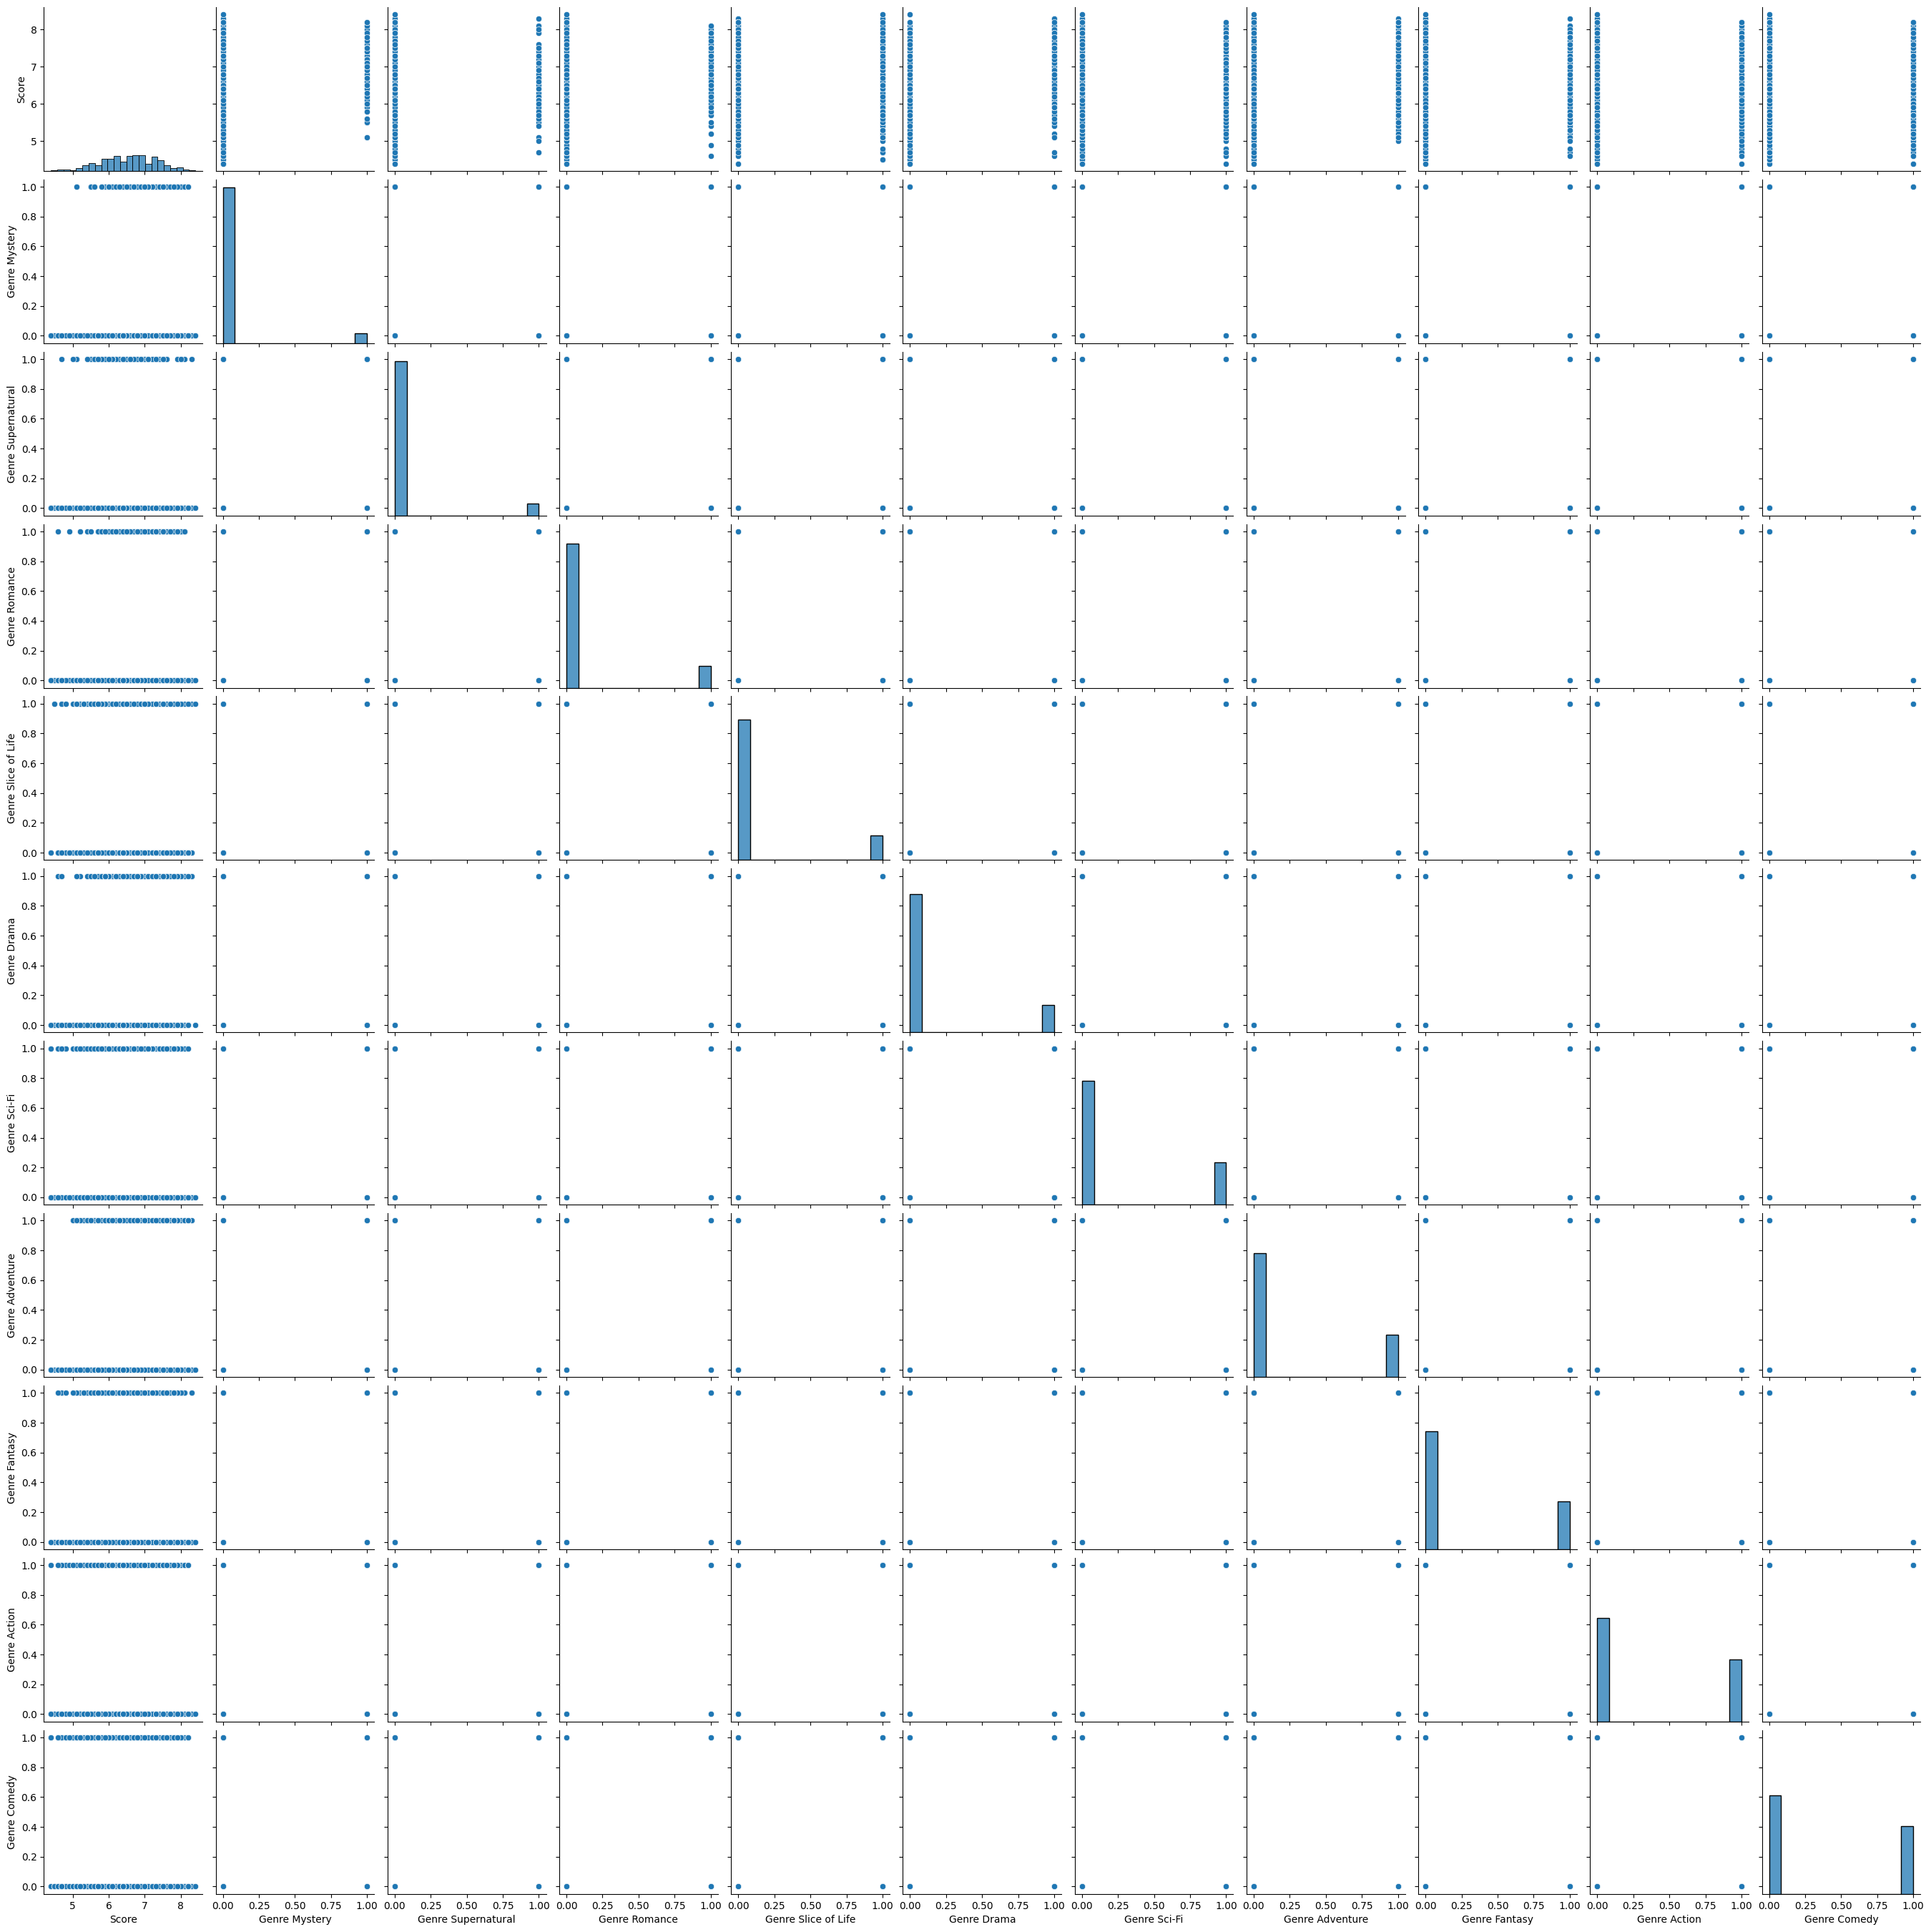

In [61]:
sns.pairplot(data, diag_kind='hist')
pass

## Аниме, произведенное в Японии, в среднем имеет больший рейтинг

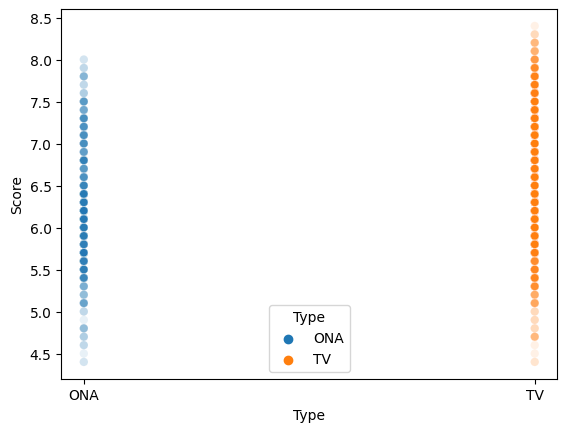

In [ ]:
sns.scatterplot(x='Type', y='Score', hue='Type', data=data, alpha=0.1)
pass

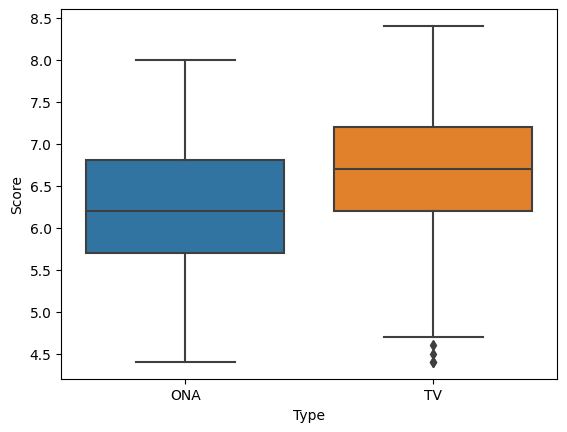

In [ ]:
sns.boxplot(x="Type", y="Score", data=data)
pass

## Аниме с большим количеством эпизодов в основном имеют высокие оценки, что можно объяснить более детальной экранизацией глав текстового источника

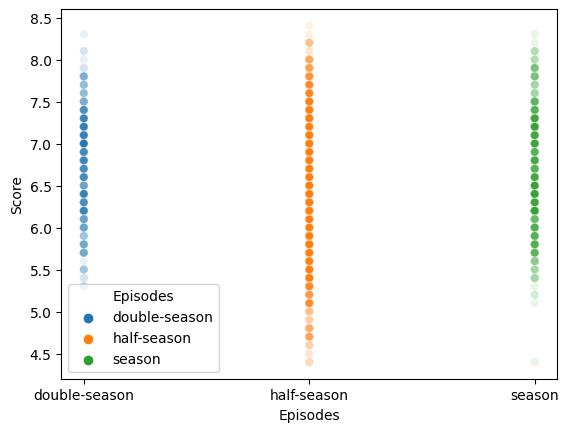

In [ ]:
sns.scatterplot(x='Episodes', y='Score', hue='Episodes', data=data, alpha=0.1)
pass

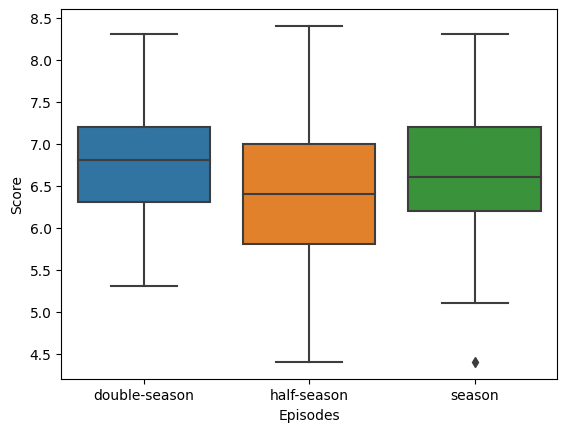

In [ ]:
sns.boxplot(x="Episodes", y="Score", data=data)
pass

## Аниме, выходящие зимой, немного выше оценены

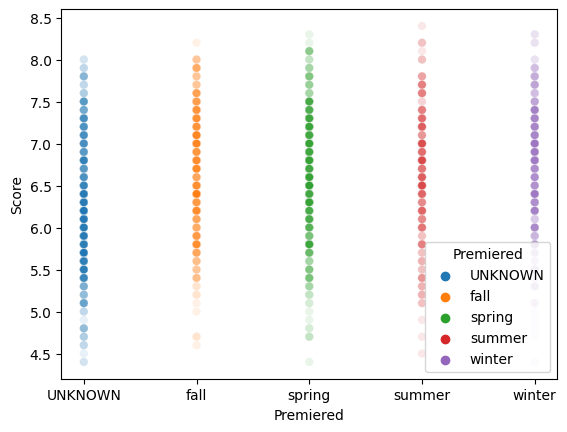

In [ ]:
sns.scatterplot(x='Premiered', y='Score', hue='Premiered', data=data, alpha=0.1)
pass

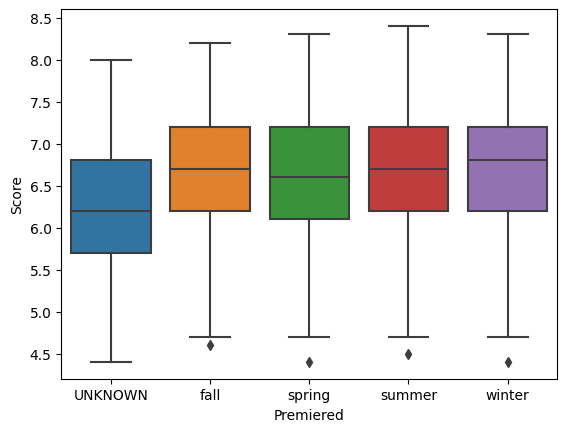

In [ ]:
sns.boxplot(x="Premiered", y="Score", data=data)
pass

## Как видно из диаграммы, аниме, имеющие такие текстовые источники, как 4-koma manga, Novel, Visual novel и Web manga, более высоко оценены

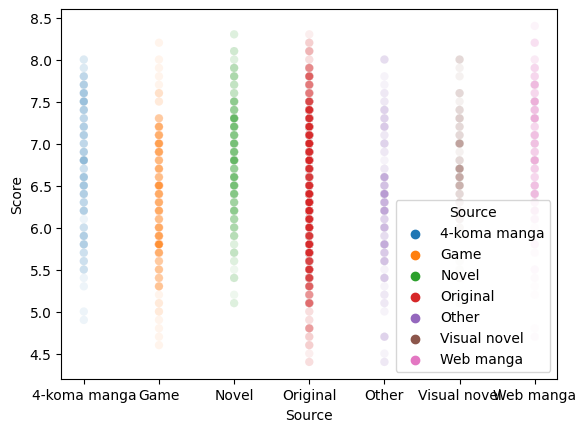

In [ ]:
sns.scatterplot(x='Source', y='Score', hue='Source', data=data, alpha=0.08)
pass

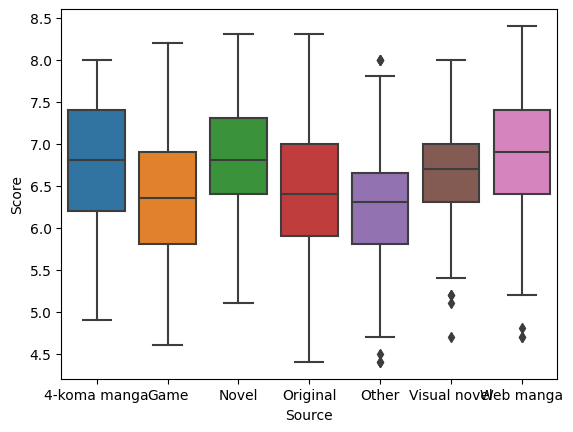

In [ ]:
sns.boxplot(x="Source", y="Score", data=data)
pass

## Корреляция

In [62]:
corr_mat = data.corr()
corr_mat

<ipython-input-62-79907eedfcac>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = data.corr()


Score  Genre Mystery  Genre Supernatural  \
Score                1.000000       0.081126            0.040654   
Genre Mystery        0.081126       1.000000            0.144738   
Genre Supernatural   0.040654       0.144738            1.000000   
Genre Romance        0.158439      -0.012332            0.029269   
Genre Slice of Life -0.020994      -0.092074           -0.042698   
Genre Drama          0.217003       0.092107            0.052252   
Genre Sci-Fi         0.044820       0.023760           -0.100631   
Genre Adventure      0.101459      -0.014901           -0.085827   
Genre Fantasy        0.050199      -0.075881           -0.065303   
Genre Action         0.046154       0.012488           -0.037792   
Genre Comedy        -0.066863      -0.110753           -0.064146   

                     Genre Romance  Genre Slice of Life  Genre Drama  \
Score                     0.158439            -0.020994     0.217003   
Genre Mystery            -0.012332            -0.092074     0.092107   
Genre Supernatural        0.029269            -0.042698     0.052252   
Genre Romance             1.000000            -0.116814     0.236416   
Genre Slice of Life      -0.116814             1.000000    -0.058350   
Genre Drama               0.236416            -0.058350     1.000000   
Genre Sci-Fi             -0.069518            -0.180654     0.021877   
Genre Adventure           0.002688            -0.202704    -0.013264   
Genre Fantasy             0.031044            -0.192821    -0.087513   
Genre Action             -0.101695            -0.297508    -0.080781   
Genre Comedy             -0.037393             0.056555    -0.203754   

                     Genre Sci-Fi  Genre Adventure  Genre Fantasy  \
Score                    0.044820         0.101459       0.050199   
Genre Mystery            0.023760        -0.014901      -0.075881   
Genre Supernatural      -0.100631        -0.085827      -0.065303   
Genre Romance           -0.069518         0.002688       0.031044   
Genre Slice of Life     -0.180654        -0.202704      -0.192821   
Genre Drama              0.021877        -0.013264      -0.087513   
Genre Sci-Fi             1.000000         0.127326      -0.216289   
Genre Adventure          0.127326         1.000000       0.237883   
Genre Fantasy           -0.216289         0.237883       1.000000   
Genre Action             0.277467         0.185724       0.156115   
Genre Comedy            -0.216298        -0.125354      -0.127135   

                     Genre Action  Genre Comedy  
Score                    0.046154     -0.066863  
Genre Mystery            0.012488     -0.110753  
Genre Supernatural      -0.037792     -0.064146  
Genre Romance           -0.101695     -0.037393  
Genre Slice of Life     -0.297508      0.056555  
Genre Drama             -0.080781     -0.203754  
Genre Sci-Fi             0.277467     -0.216298  
Genre Adventure          0.185724     -0.125354  
Genre Fantasy            0.156115     -0.127135  
Genre Action             1.000000     -0.327751  
Genre Comedy            -0.327751      1.000000

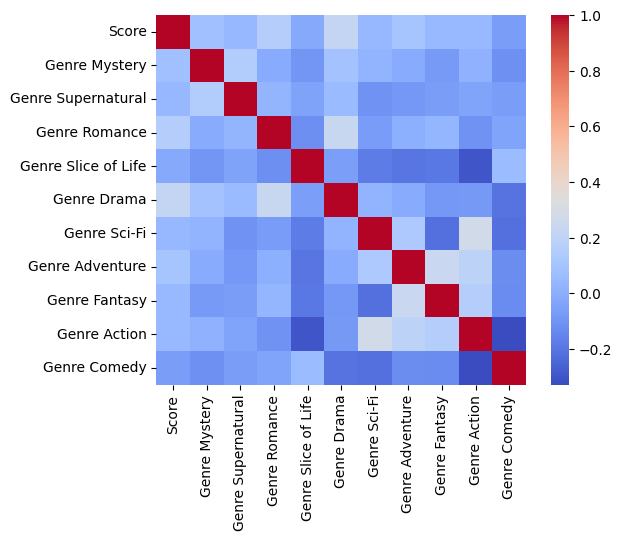

In [63]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

### Так как признаки бинарные и до разбиения были частью составного признака, корреляция в основном показывает как часто 2 жанра встречаются вместе

In [64]:
corr_mat.where(np.triu(corr_mat > 0.1, k=1)).stack().sort_values(ascending=False)

Genre Sci-Fi     Genre Action          0.277467
Genre Adventure  Genre Fantasy         0.237883
Genre Romance    Genre Drama           0.236416
Score            Genre Drama           0.217003
Genre Adventure  Genre Action          0.185724
Score            Genre Romance         0.158439
Genre Fantasy    Genre Action          0.156115
Genre Mystery    Genre Supernatural    0.144738
Genre Sci-Fi     Genre Adventure       0.127326
Score            Genre Adventure       0.101459
dtype: float64

# 9. Нормализация

## Не учитываем столбец Premiered как особо не влияющий на Score

In [65]:
data = pd.concat((data, pd.get_dummies(data['Type'])), axis=1)
data = pd.concat((data, pd.get_dummies(data['Episodes'])), axis=1)
data = pd.concat((data, pd.get_dummies(data['Source'])), axis=1)
data = pd.concat((data, pd.get_dummies(data['Rating'])), axis=1)

data.drop('Type', inplace=True, axis=1)
data.drop('Episodes', inplace=True, axis=1)
data.drop('Source', inplace=True, axis=1)
data.drop('Rating', inplace=True, axis=1)
data.drop('Premiered', inplace=True, axis=1)
data.shape

(1780, 28)

## Корреляция с учетом бинаризации номинальных признаков

In [66]:
corr_mat = data.corr()
corr_mat.where(np.triu(corr_mat > 0.25, k=1)).stack().sort_values(ascending=False)

<ipython-input-66-9694c357df55>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = data.corr()


Genre Romance  Visual novel    0.369510
Genre Comedy   4-koma manga    0.287302
Genre Sci-Fi   Genre Action    0.277467
dtype: float64

# 10. Machine learning

## Разбиение данных

In [ ]:
from sklearn.model_selection import train_test_split

# TODO use synopsis
X = data.drop(['Score', 'Synopsis'], axis=1)
y = data['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 777)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(1370, 457)

## Метод ближайших соседей

### Коэффициент R2 получился довольно низким, что указывает на близость модели к константному предсказанию, что не очень хорошо

In [ ]:
from sklearn import neighbors
knn_model = neighbors.KNeighborsRegressor(n_neighbors = 5)
knn_model.fit(X_train, y_train)
knn_model.score(X_test, y_test)

0.16854739130216023

### Из прикладных соображений далее попробуем использовать собственную метрику качества. Если предсказанное значение отличается от истинного не более чем на 0.2, то ошибка = 0. В противном случае считаем сколько раз 0.2 помещается между предсказанным и истинным значениями и нормируем на половину размаха значений Score (4.4 - 8.4)

In [ ]:
import math
def my_score(y_predict_test, y_test):
  errors=[]
  y_test = y_test.tolist()
  for i in range(len(y_predict_test)):
    errors.append(math.floor(abs(y_predict_test[i]-y_test[i])/0.2)/((8.4-4.4)/2/0.2))
  return 1-np.mean(errors)

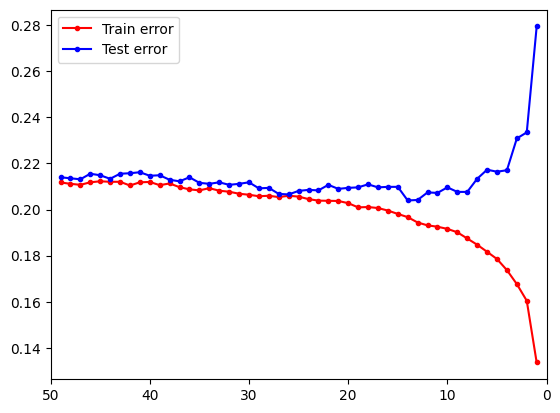

In [ ]:
from sklearn import neighbors
kk = range(1, 50)
err_train = []
err_test = []
for k in kk:
    model = neighbors.KNeighborsRegressor(n_neighbors = k)
    model.fit(X_train, y_train)
    err_train.append(1-my_score(model.predict(X_train), y_train))
    err_test.append(1-my_score(model.predict(X_test), y_test))
plt.plot(kk, err_train, '.-r', label = 'Train error')
plt.plot(kk, err_test,  '.-b', label = 'Test error')
plt.legend(loc = 0)
plt.xlim([50, 0])
pass

### Весьма неплохие результаты, стоит отметить, что потребовалось большое кол-во соседей

In [ ]:
knn_model = neighbors.KNeighborsRegressor(n_neighbors = 14)
knn_model.fit(X_train, y_train)
my_score(knn_model.predict(X_test), y_test)

0.7960612691466082

## Линейная регрессия

In [ ]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
my_score(lr_model.predict(X_test), y_test)

0.788183807439825

### Анализируя коэффициенты, можно сделать выводы, что жанры Romance и Drama сильнее влияют на оценку, чем остальные, что интуитивно очевидно. Адекватно интерпретировать остальные коэффициенты не удается ввиду того, что они относятся к номинальным признакам

In [ ]:
data.columns

Index(['Score', 'Genre Mystery', 'Genre Supernatural', 'Genre Romance',
       'Genre Slice of Life', 'Genre Drama', 'Genre Sci-Fi', 'Genre Adventure',
       'Genre Fantasy', 'Genre Action', 'Genre Comedy', 'ONA', 'TV',
       'double-season', 'half-season', 'season', '4-koma manga', 'Game',
       'Novel', 'Original', 'Other', 'Visual novel', 'Web manga',
       'G - All Ages', 'PG - Children', 'PG-13 - Teens 13 or older',
       'R - 17+ (violence & profanity)'],
      dtype='object')

In [ ]:
lr_model.coef_

array([ 1.43164823e-01,  7.90147905e-02,  3.11262711e-01,  1.24979309e-01,
        3.33417448e-01,  9.96874070e-02,  2.51689779e-02,  1.42149096e-01,
        5.96500293e-02,  4.76882963e-02, -3.47378774e+12, -3.47378774e+12,
       -2.91188687e+13, -2.91188687e+13, -2.91188687e+13,  7.95738042e+12,
        7.95738042e+12,  7.95738042e+12,  7.95738042e+12,  7.95738042e+12,
        7.95738042e+12,  7.95738042e+12,  1.20891539e+13,  1.20891539e+13,
        1.20891539e+13,  1.20891539e+13])

## Случайный лес

In [ ]:
from sklearn import ensemble
scores = []
for i in range (100):
  rf_model = ensemble.RandomForestRegressor(n_estimators = 100)
  rf_model.fit(X_train, y_train)
  scores.append(my_score(rf_model.predict(X_test), y_test))
print(min(scores))
print(np.mean(scores))
print(max(scores))

0.7811816192560175
0.7847768052516412
0.7886214442013129


## Метод опорных векторов

In [ ]:
from sklearn import svm
svm_model = svm.SVR(kernel='rbf')
svm_model.fit(X_train, y_train)
my_score(svm_model.predict(X_test), y_test)

0.798687089715536

## Из рассмотренных алгоритмов лучше (пусть и не намного) справляются с задачей метод k ближайших соседей и машина опорных векторов. Далее сравним эти 2 метода с учетом кросс-валидации

In [ ]:
X = data.drop(['Score'], axis=1)
y = data['Score']
res_knn=[]
res_svm=[]
for i in range (10):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = i)
  kk = range(1, 100)
  err=1
  best_k=1
  for k in kk:
      model = neighbors.KNeighborsRegressor(n_neighbors = k)
      model.fit(X_train, y_train)
      if err > 1-my_score(model.predict(X_train), y_train):
        err = 1-my_score(model.predict(X_test), y_test)
        best_k = k
  res_knn.append((1-err, best_k))

  svm_model = svm.SVR(kernel='rbf')
  svm_model.fit(X_train, y_train)
  res_svm.append(my_score(svm_model.predict(X_test), y_test))

### В итоге в среднем точность алгоритма ближайших соседей меньше и она в основном достигается при большом n_neighbors, в то время как более высокая точность при удачном разбиении данных достигается при небольшом n_neighbors

In [ ]:
np.mean(res_svm)

0.7914207650273223

In [ ]:
knn_score=[]
for res in res_knn:
  knn_score.append(res[0])
print(np.mean(knn_score))
res_knn

0.7757923497267759


[(0.7789617486338798, 94),
 (0.7734972677595628, 99),
 (0.7672131147540984, 99),
 (0.7707650273224044, 99),
 (0.7942622950819672, 25),
 (0.7860655737704918, 52),
 (0.7846994535519125, 50),
 (0.7655737704918033, 99),
 (0.7562841530054645, 99),
 (0.7806010928961749, 99)]

### Ради интереса запустим обучение на всей выборке и протестируем на нескольких примерах других данных, кол-во соседей возьмем 25

In [ ]:
X = data.drop(['Score'], axis=1)
y = data['Score']

knn_model = neighbors.KNeighborsRegressor(n_neighbors = 25)
knn_model.fit(X, y)

svm_model = svm.SVR(kernel='rbf')
svm_model.fit(X, y)
pass

In [ ]:
data.columns

Index(['Score', 'Genre Mystery', 'Genre Supernatural', 'Genre Romance',
       'Genre Slice of Life', 'Genre Drama', 'Genre Sci-Fi', 'Genre Adventure',
       'Genre Fantasy', 'Genre Action', 'Genre Comedy', 'ONA', 'TV',
       'double-season', 'half-season', 'season', '4-koma manga', 'Game',
       'Novel', 'Original', 'Other', 'Visual novel', 'Web manga',
       'G - All Ages', 'PG - Children', 'PG-13 - Teens 13 or older',
       'R - 17+ (violence & profanity)'],
      dtype='object')

In [ ]:
# One Piece: rating 8.7
print(knn_model.predict([[0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0]]))
print(svm_model.predict([[0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0]]))

[6.516]
[7.313842]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [ ]:
# Oshi no Ko: rating 8.8
print(knn_model.predict([[0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0]]))
print(svm_model.predict([[0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0]]))

[6.94]
[7.29443556]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


### Очевидно, что используемых признаков недостаточно, и более того, они не учитывают уникальность сюжета